## 1. 데이터 읽기와 전처리, 및 확인

In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 1. CSV 파일 로드
data = pd.read_csv('미국 옥수수 선물 과거 데이터 (1).csv')  # 'your_file.csv'를 실제 파일 이름으로 변경

# 2. 데이터 분할 (80% 학습, 20% 테스트)
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# 3. 결과 확인
print("학습용 데이터 크기:", train_data.shape)
print("백테스팅용 데이터 크기:", test_data.shape)

# 4. 필요하면 저장
train_data.to_csv('train_data.csv', index=False)
test_data.to_csv('test_data.csv', index=False)

학습용 데이터 크기: (868, 7)
백테스팅용 데이터 크기: (217, 7)


In [3]:
!pip install holidays

In [11]:
import pandas as pd
import holidays  # 미국 공휴일 데이터를 가져오기 위한 라이브러리

# 1. 데이터 로드
data = pd.read_csv('가격데이터.csv')
data.columns = ['Date', 'Close', 'Open', 'High', 'Low', 'Volume', 'Change_Pct']

# 2. 날짜를 인덱스로 설정 및 요일 컬럼 추가
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data['Weekday'] = data.index.day_name()

# 3. 거래량 전처리: 'K' 제거 및 숫자 변환 (예: '223.84K' -> 223840)
data['Volume'] = data['Volume'].str.replace('K', '').astype(float) * 1000

# 개선: 거래량 정규화 (평균 대비 비율)
data['Volume_Norm'] = data['Volume'] / data['Volume'].mean()

# 4. 공휴일 처리 개선
# 미국 공휴일 데이터 로드 (holidays 라이브러리 사용)
us_holidays = holidays.US(years=[2023, 2024, 2025])

# 공휴일 여부 컬럼 추가
data['IsHoliday'] = data.index.map(lambda x: x in us_holidays)

# 월요일 데이터 확인 및 공휴일 처리
data['IsMonday'] = data['Weekday'] == 'Monday'
data['IsTuesday'] = data['Weekday'] == 'Tuesday'

# 공휴일인 월요일 데이터는 제외 (또는 보간 처리 가능)
data_monday = data[data['IsMonday'] & ~data['IsHoliday']].copy()

# 5. 금요일 데이터와 월요일 시초가 연결
data.sort_index(ascending=True, inplace=True)
data['NextOpen'] = data['Open'].shift(-1)  # 다음 거래일 시초가

# 금요일 데이터에 월요일 시초가를 연결
data['MondayOpen'] = None
for i in range(len(data)):
    if data.iloc[i]['Weekday'] == 'Friday':
        for j in range(i + 1, len(data)):
            if data.iloc[j]['IsMonday'] and not data.iloc[j]['IsHoliday']:
                data.iloc[i, data.columns.get_loc('MondayOpen')] = data.iloc[j]['Open']
                break
            elif data.iloc[j]['IsTuesday']:  # 월요일이 공휴일이면 화요일 시초가 사용
                data.iloc[i, data.columns.get_loc('MondayOpen')] = data.iloc[j]['Open']
                break

# 6. 금요일 데이터 추출 및 계산
data['Fri_Close_Low'] = data['Close'] - data['Low']  # 종가-저가 차이
data['Fri_High_Low'] = data['High'] - data['Low']   # 고가-저가 차이 (변동폭)

# 개선: 갭을 비율(%)로 계산
data['Gap'] = data['MondayOpen'] - data['Close']  # 기존 갭 (절대값)
data['Gap_Pct'] = (data['Gap'] / data['Close']) * 100  # 갭 비율 (%)

# 금요일 데이터만 필터링
data_friday = data[data['Weekday'] == 'Friday'].copy()

# 7. 결측치 확인 및 처리
print("결측치 확인:")
print(data_friday.isna().sum())
data_friday.dropna(subset=['MondayOpen', 'Gap', 'Gap_Pct'], inplace=True)

# 8. 결과 확인
print("전처리된 데이터 (금요일 기준):")
print(data_friday[['Close', 'Low', 'Fri_Close_Low', 'Fri_High_Low', 'Volume', 'Volume_Norm', 'MondayOpen', 'Gap', 'Gap_Pct']].head())

# 9. 전처리된 데이터 저장
data_friday.to_csv('processed_natural_gas_data.csv')

결측치 확인:
Close            0
Open             0
High             0
Low              0
Volume           0
Change_Pct       0
Weekday          0
Volume_Norm      0
IsHoliday        0
IsMonday         0
IsTuesday        0
NextOpen         1
MondayOpen       1
Fri_Close_Low    0
Fri_High_Low     0
Gap              1
Gap_Pct          1
dtype: int64
전처리된 데이터 (금요일 기준):
            Close    Low  Fri_Close_Low  Fri_High_Low    Volume  Volume_Norm  \
Date                                                                           
2021-01-08  2.656  2.603          0.053         0.082   89980.0     0.903227   
2021-01-15  2.696  2.606          0.090         0.142   91100.0     0.914470   
2021-01-22  2.456  2.425          0.031         0.086   97290.0     0.976606   
2021-01-29  2.592  2.583          0.009         0.133   62370.0     0.626076   
2021-02-05  2.841  2.823          0.018         0.157  155020.0     1.556105   

           MondayOpen    Gap   Gap_Pct  
Date                               

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1118 entries, 2021-01-04 to 2025-04-04
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Close          1118 non-null   float64
 1   Open           1118 non-null   float64
 2   High           1118 non-null   float64
 3   Low            1118 non-null   float64
 4   Volume         1070 non-null   float64
 5   Change_Pct     1118 non-null   object 
 6   Weekday        1118 non-null   object 
 7   Volume_Norm    1070 non-null   float64
 8   IsHoliday      1118 non-null   bool   
 9   IsMonday       1118 non-null   bool   
 10  IsTuesday      1118 non-null   bool   
 11  NextOpen       1117 non-null   float64
 12  MondayOpen     216 non-null    object 
 13  Fri_Close_Low  1118 non-null   float64
 14  Fri_High_Low   1118 non-null   float64
 15  Gap            216 non-null    object 
 16  Gap_Pct        216 non-null    object 
dtypes: bool(3), float64(9), object(5)


In [13]:
data.tail()

,Close,Open,High,Low,Volume,Change_Pct,Weekday,Volume_Norm,IsHoliday,IsMonday,IsTuesday,NextOpen,MondayOpen,Fri_Close_Low,Fri_High_Low,Gap,Gap_Pct
Date,,,,,,,,,,,,,,,,,
2025-03-31,4.119,4.176,4.253,4.055,171860.0,1.33%,Monday,1.725146,False,True,False,4.132,None,0.064,0.198,NaN,NaN
2025-04-01,3.951,4.132,4.148,3.934,156690.0,-4.08%,Tuesday,1.572869,False,False,True,3.950,None,0.017,0.214,NaN,NaN
2025-04-02,4.055,3.950,4.089,3.935,141240.0,2.63%,Wednesday,1.417780,False,False,False,4.011,None,0.120,0.154,NaN,NaN
2025-04-03,4.138,4.011,4.203,3.968,165410.0,2.05%,Thursday,1.660401,False,False,False,4.148,None,0.170,0.235,NaN,NaN
2025-04-04,3.824,4.148,4.151,3.811,223840.0,-7.59%,Friday,2.246926,False,False,False,NaN,None,0.013,0.340,NaN,NaN


In [14]:
data_friday.tail()

,Close,Open,High,Low,Volume,Change_Pct,Weekday,Volume_Norm,IsHoliday,IsMonday,IsTuesday,NextOpen,MondayOpen,Fri_Close_Low,Fri_High_Low,Gap,Gap_Pct
Date,,,,,,,,,,,,,,,,,
2025-02-28,3.834,3.939,3.954,3.814,141990.0,-2.54%,Friday,1.425309,False,False,False,3.779,3.779,0.020,0.140,-0.055,-1.434533
2025-03-07,4.399,4.286,4.426,4.132,211900.0,2.25%,Friday,2.127072,False,False,False,4.467,4.467,0.267,0.294,0.068,1.545806
2025-03-14,4.104,4.040,4.141,3.962,144410.0,-0.17%,Friday,1.449601,False,False,False,4.187,4.187,0.142,0.179,0.083,2.022417
2025-03-21,4.024,4.035,4.089,3.931,118070.0,-0.35%,Friday,1.185197,False,False,False,3.880,3.88,0.093,0.158,-0.144,-3.578529
2025-03-28,4.065,3.915,4.100,3.836,176360.0,2.91%,Friday,1.770318,False,False,False,4.176,4.176,0.229,0.264,0.111,2.730627


## 2. 분석 목표(월요일 시초가 움직임) 시각화 

- **갭 정의 및 범주화**
  - 갭 방향: 상승/하락/없음
  - 갭 크기: 절대값 기준 범주화

- **월별/계절별 분석**
  - 월별 갭 방향 비율
  - 겨울철(11-2월) vs 여름철(5-8월) 비교
  - 연도별/월별 갭 패턴

- **특이 케이스 분석**
  - 비정상 갭(±10% 이상) 탐지
  - 계절성 영향 확인

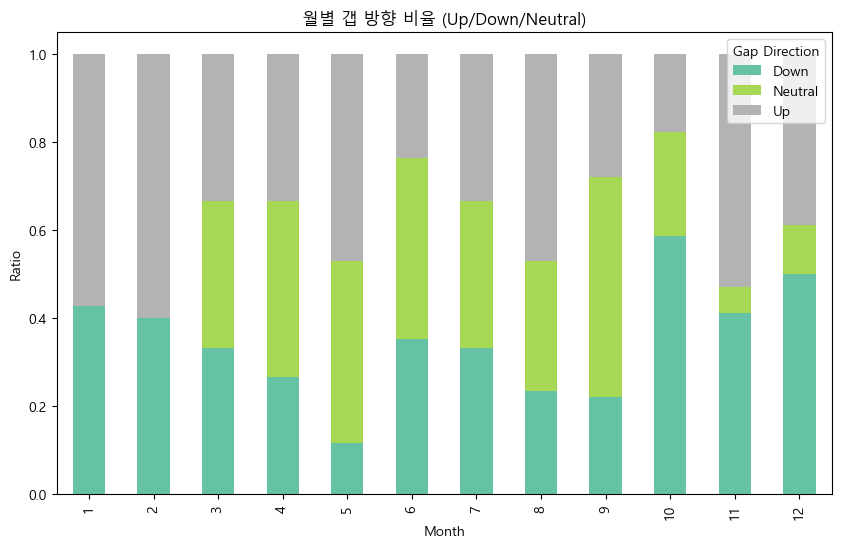

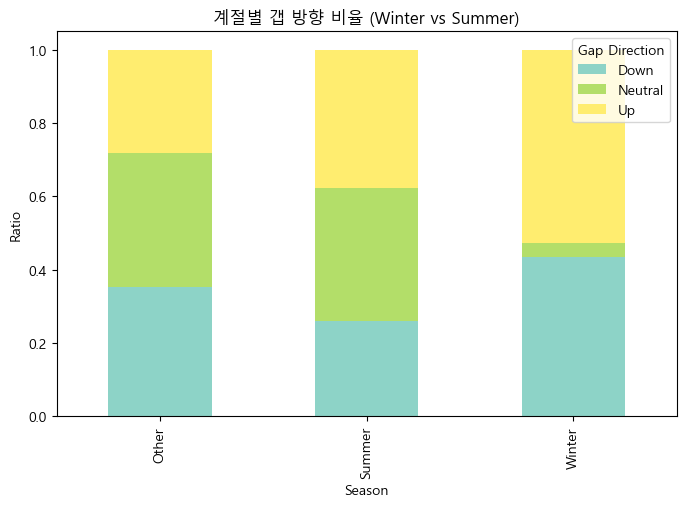


갭 비율 이상치 (±10% 이상):
            Close  MondayOpen    Gap_Pct  Season
Date                                            
2023-02-24  2.548       2.811  10.321821  Winter
2024-04-26  1.923       2.282  18.668747   Other
2024-12-13  3.280       2.710 -17.378049  Winter
2024-12-20  3.412       3.869  13.393904  Winter
2025-01-17  3.948       3.392 -14.083080  Winter


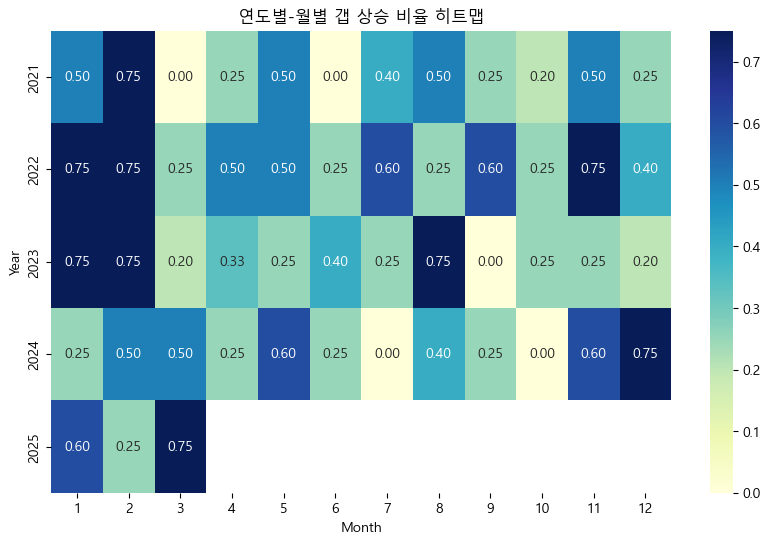

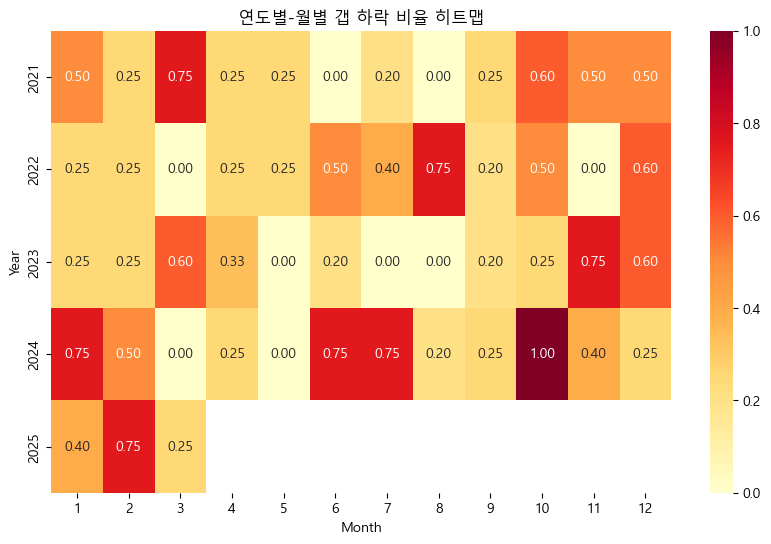

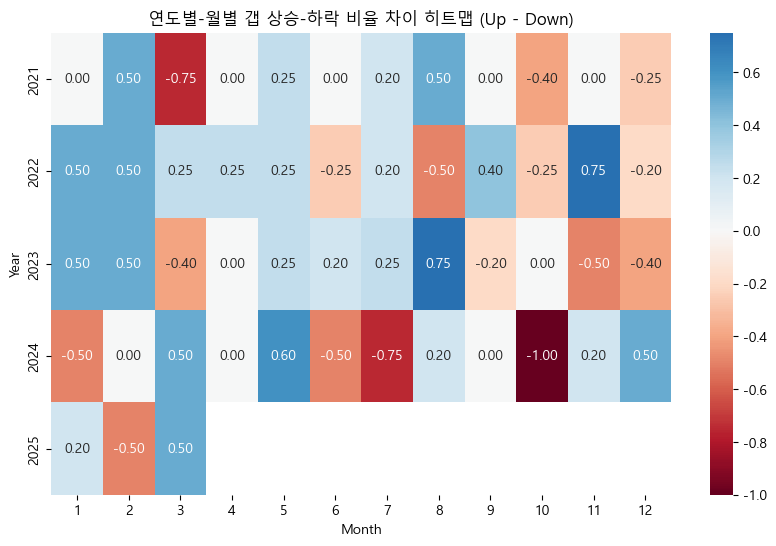

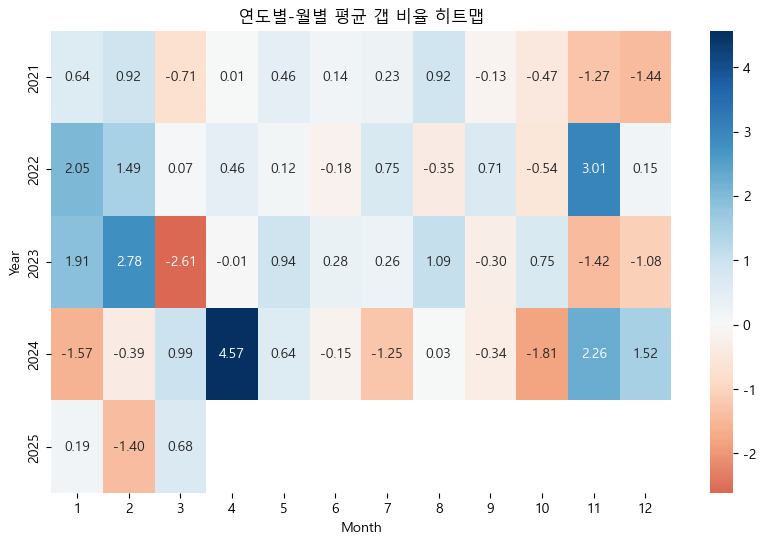

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# 1. 데이터 로드
data_friday = pd.read_csv('processed_natural_gas_data.csv')
data_friday['Date'] = pd.to_datetime(data_friday['Date'])
data_friday.set_index('Date', inplace=True)

# 2. 갭 방향 정의
def classify_gap(gap_pct):
    if gap_pct > 0.5:
        return 'Up'
    elif gap_pct < -0.5:
        return 'Down'
    else:
        return 'Neutral'

data_friday['Gap_Direction'] = data_friday['Gap_Pct'].apply(classify_gap)

# 3. 갭 크기 범주화
bins = [-float('inf'), -2, -1, 0, 1, 2, float('inf')]
labels = ['<-2%', '-2% to -1%', '-1% to 0%', '0% to 1%', '1% to 2%', '>2%']
data_friday['Gap_Size_Category'] = pd.cut(data_friday['Gap_Pct'], bins=bins, labels=labels)

# 4. 월별 갭 비율 계산
data_friday['Month'] = data_friday.index.month
monthly_gap_direction = data_friday.groupby('Month')['Gap_Direction'].value_counts(normalize=True).unstack().fillna(0)

# 5. 시각화 1: 월별 갭 방향 비율
monthly_gap_direction.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='Set2')
plt.title('월별 갭 방향 비율 (Up/Down/Neutral)')
plt.xlabel('Month')
plt.ylabel('Ratio')
plt.legend(title='Gap Direction')
plt.show()

# 6. 시각화 2: 갭 크기 분포
fig = px.histogram(data_friday, x='Gap_Size_Category', title='갭 크기 분포',
                   category_orders={'Gap_Size_Category': labels})
fig.update_layout(xaxis_title='Gap Size Category', yaxis_title='Count')
fig.show()

# 디벨롭 1: 계절성 분석 강화
def classify_season(month):
    if month in [11, 12, 1, 2]:
        return 'Winter'
    elif month in [5, 6, 7, 8]:
        return 'Summer'
    else:
        return 'Other'

data_friday['Season'] = data_friday['Month'].apply(classify_season)
seasonal_gap = data_friday.groupby('Season')['Gap_Direction'].value_counts(normalize=True).unstack().fillna(0)

# 시각화 3: 계절별 갭 방향 비율
seasonal_gap.plot(kind='bar', stacked=True, figsize=(8, 5), colormap='Set3')
plt.title('계절별 갭 방향 비율 (Winter vs Summer)')
plt.xlabel('Season')
plt.ylabel('Ratio')
plt.legend(title='Gap Direction')
plt.show()

# 디벨롭 2: 이상치 탐지
outliers = data_friday[abs(data_friday['Gap_Pct']) >= 10]
print("\n갭 비율 이상치 (±10% 이상):")
print(outliers[['Close', 'MondayOpen', 'Gap_Pct', 'Season']])

if not outliers.empty:
    fig = px.scatter(outliers, x=outliers.index, y='Gap_Pct', color='Season',
                     title='갭 비율 이상치 (±10% 이상)',
                     labels={'Gap_Pct': 'Gap %', 'index': 'Date'})
    fig.show()
else:
    print("이상치(±10% 이상)가 없습니다.")

# 연도별-월별 갭 분석
data_friday['Year'] = data_friday.index.year
data_friday['Month'] = data_friday.index.month

# 연도별-월별 갭 방향 비율 계산
year_month_gap = data_friday.groupby(['Year', 'Month'])['Gap_Direction'].value_counts(normalize=True).unstack().fillna(0)

# 갭 상승 비율 히트맵
year_month_gap_up = year_month_gap['Up'].unstack()
plt.figure(figsize=(10, 6))
sns.heatmap(year_month_gap_up, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('연도별-월별 갭 상승 비율 히트맵')
plt.xlabel('Month')
plt.ylabel('Year')
plt.show()

# 갭 하락 비율 히트맵
year_month_gap_down = year_month_gap['Down'].unstack()
plt.figure(figsize=(10, 6))
sns.heatmap(year_month_gap_down, annot=True, cmap='YlOrRd', fmt='.2f')
plt.title('연도별-월별 갭 하락 비율 히트맵')
plt.xlabel('Month')
plt.ylabel('Year')
plt.show()

# 대안: 갭 상승-하락 비율 차이 히트맵
year_month_gap_diff = (year_month_gap['Up'] - year_month_gap['Down']).unstack()
plt.figure(figsize=(10, 6))
sns.heatmap(year_month_gap_diff, annot=True, cmap='RdBu', fmt='.2f', center=0)
plt.title('연도별-월별 갭 상승-하락 비율 차이 히트맵 (Up - Down)')
plt.xlabel('Month')
plt.ylabel('Year')
plt.show()

# 연도별-월별 평균 갭 비율 계산 및 시각화
year_month_avg_gap = data_friday.groupby(['Year', 'Month'])['Gap_Pct'].mean().unstack()

# 시각화: 연도별-월별 평균 갭 비율 히트맵
plt.figure(figsize=(10, 6))
sns.heatmap(year_month_avg_gap, annot=True, cmap='RdBu', fmt='.2f', center=0)
plt.title('연도별-월별 평균 갭 비율 히트맵')
plt.xlabel('Month')
plt.ylabel('Year')
plt.show()

## 3. 금요일와 관계 분석


금요일 변수와 갭 비율(Gap_Pct) 간 상관계수:
Fri_Close_Low: 0.080
Fri_High_Low: 0.007
Volume_Norm: 0.015
HighLow_Volume_Interaction: -0.026


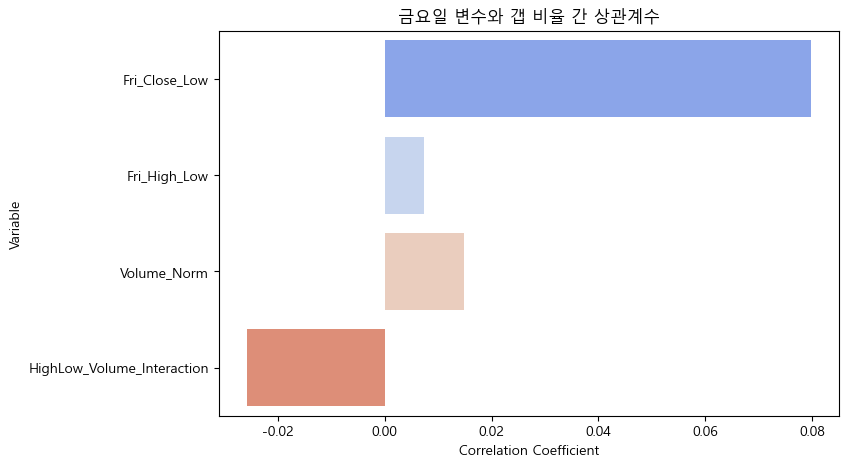


Random Forest 변수 중요도:
Fri_Close_Low                 0.249107
Fri_High_Low                  0.244919
Volume_Norm                   0.252873
HighLow_Volume_Interaction    0.253101
dtype: float64


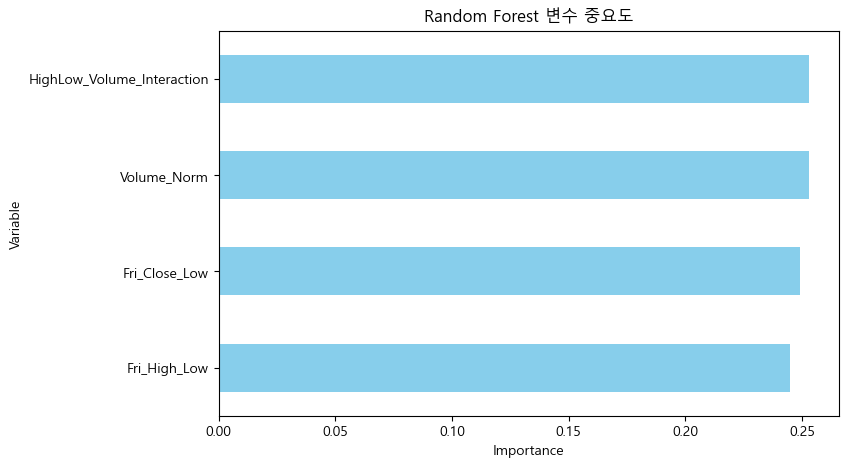


XGBoost 변수 중요도:
Fri_Close_Low                 0.240660
Fri_High_Low                  0.234275
Volume_Norm                   0.280129
HighLow_Volume_Interaction    0.244936
dtype: float32


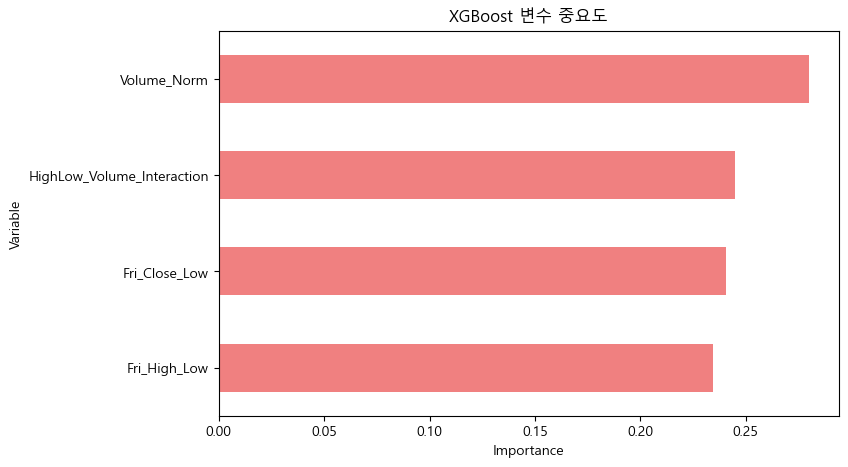


의사결정트리 시각화 파일이 'decision_tree.png'로 저장되었습니다.

모델별 F1 스코어 (Weighted):
Random Forest: 1.000
XGBoost: 1.000
Decision Tree: 0.560


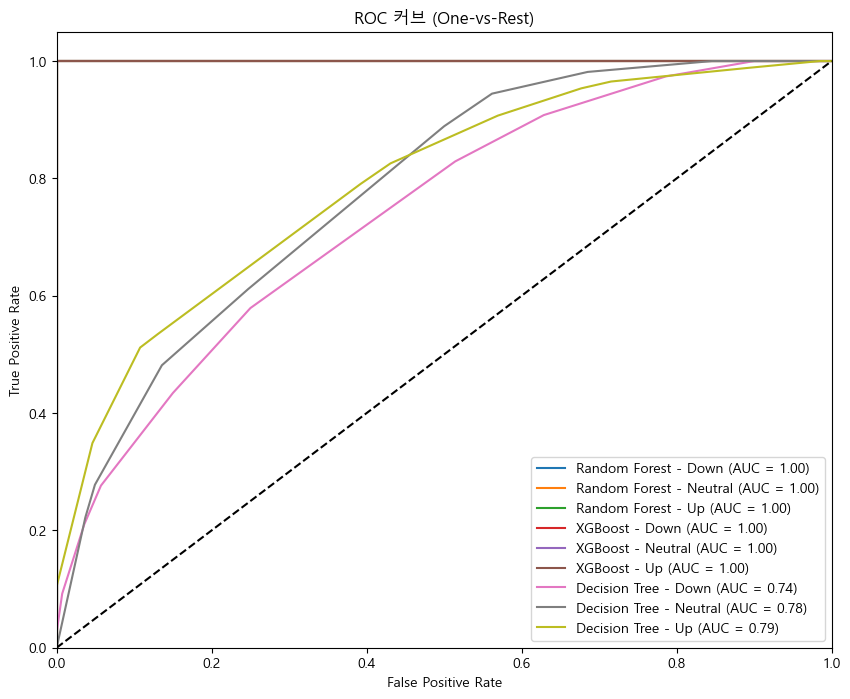


도지 캔들 여부와 갭 방향 비율:
Gap_Direction      Down   Neutral        Up
Doji                                       
0              0.350711  0.246445  0.402844
1              0.400000  0.400000  0.200000


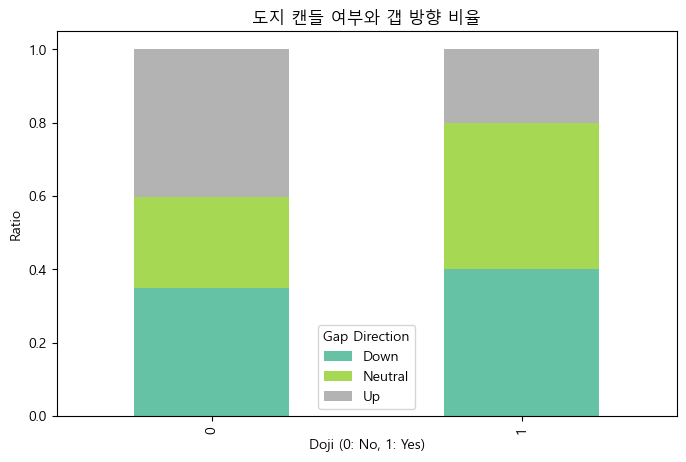


계절별 금요일 변수와 갭 비율 간 상관계수:

Winter:
Fri_Close_Low: 0.143
Fri_High_Low: 0.047
Volume_Norm: -0.091
HighLow_Volume_Interaction: -0.081

Other:
Fri_Close_Low: 0.011
Fri_High_Low: -0.022
Volume_Norm: 0.195
HighLow_Volume_Interaction: 0.051

Summer:
Fri_Close_Low: 0.017
Fri_High_Low: -0.079
Volume_Norm: 0.127
HighLow_Volume_Interaction: -0.001


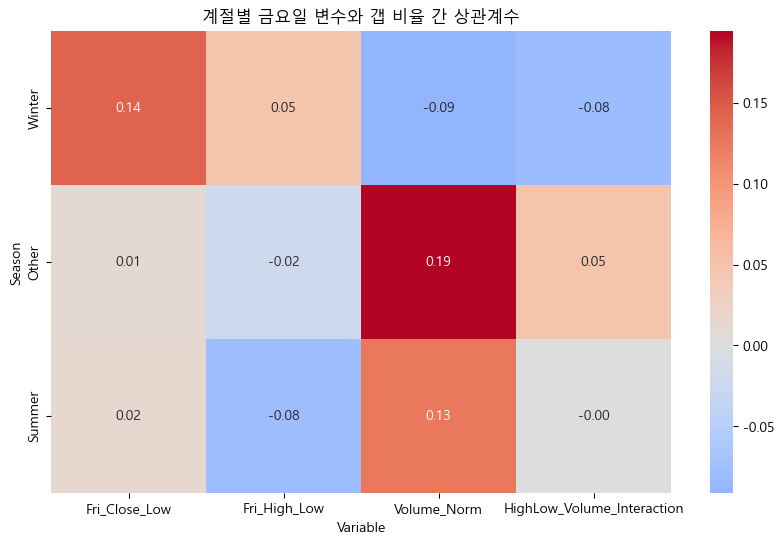

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.font_manager as fm
import numpy as np
import graphviz

# 한글 폰트 설정 (Malgun Gothic 대신 다른 폰트로 대체하거나 설정 조정)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 1. 데이터 로드
data_friday = pd.read_csv('processed_natural_gas_data.csv')
data_friday['Date'] = pd.to_datetime(data_friday['Date'])
data_friday.set_index('Date', inplace=True)

# Month 컬럼 생성 (오류 수정)
data_friday['Month'] = data_friday.index.month

# 갭 방향 정의
def classify_gap(gap_pct):
    if gap_pct > 0.5:
        return 'Up'
    elif gap_pct < -0.5:
        return 'Down'
    else:
        return 'Neutral'

data_friday['Gap_Direction'] = data_friday['Gap_Pct'].apply(classify_gap)

# 상호작용 항 추가
data_friday['HighLow_Volume_Interaction'] = data_friday['Fri_High_Low'] * data_friday['Volume_Norm']

# 2. 변수 설정
variables = ['Fri_Close_Low', 'Fri_High_Low', 'Volume_Norm', 'HighLow_Volume_Interaction']

# 3. 상관분석
correlations = {}
for var in variables:
    corr, _ = pearsonr(data_friday[var], data_friday['Gap_Pct'])
    correlations[var] = corr

print("\n금요일 변수와 갭 비율(Gap_Pct) 간 상관계수:")
for var, corr in correlations.items():
    print(f"{var}: {corr:.3f}")

# 상관계수 시각화 (FutureWarning 수정)
plt.figure(figsize=(8, 5))
sns.barplot(x=list(correlations.values()), y=list(correlations.keys()), hue=list(correlations.keys()), palette='coolwarm', legend=False)
plt.title('금요일 변수와 갭 비율 간 상관계수')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Variable')
plt.show()

# 4. 모델 학습 및 중요도 분석
X = data_friday[variables]
y = data_friday['Gap_Direction']

# 갭 방향 레이블 인코딩
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 모델 리스트
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='mlogloss'),  # use_label_encoder 제거
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=4)  # 트리 깊이 제한
}

# 모델 학습 및 평가
f1_scores = {}
y_pred_dict = {}

for name, model in models.items():
    model.fit(X, y_encoded)
    y_pred = model.predict(X)
    f1 = f1_score(y_encoded, y_pred, average='weighted')
    f1_scores[name] = f1
    y_pred_dict[name] = y_pred

    # 변수 중요도 출력 및 시각화
    if name != 'Decision Tree':  # 의사결정트리는 별도로 시각화
        importances = pd.Series(model.feature_importances_, index=variables)
        print(f"\n{name} 변수 중요도:")
        print(importances)
        plt.figure(figsize=(8, 5))
        importances.sort_values().plot(kind='barh', color='skyblue' if name == 'Random Forest' else 'lightcoral')
        plt.title(f'{name} 변수 중요도')
        plt.xlabel('Importance')
        plt.ylabel('Variable')
        plt.show()

# 의사결정트리 시각화
dt_model = models['Decision Tree']
dot_data = export_graphviz(dt_model, out_file=None, feature_names=variables, class_names=le.classes_, filled=True)
graph = graphviz.Source(dot_data)
graph.render("decision_tree", view=True, format='png')  # PNG 파일로 저장 및 표시
print("\n의사결정트리 시각화 파일이 'decision_tree.png'로 저장되었습니다.")

# F1 스코어 출력
print("\n모델별 F1 스코어 (Weighted):")
for name, score in f1_scores.items():
    print(f"{name}: {score:.3f}")

# 5. ROC 커브 (One-vs-Rest 방식)
y_bin = label_binarize(y_encoded, classes=[0, 1, 2])  # Up, Down, Neutral
n_classes = y_bin.shape[1]
class_names = le.classes_

plt.figure(figsize=(10, 8))
for name, model in models.items():
    y_score = model.predict_proba(X)
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} - {class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC 커브 (One-vs-Rest)')
plt.legend(loc="lower right")
plt.show()

# 6. 변수와 갭 비율 간 관계 시각화 (산점도)
for var in variables:
    fig = px.scatter(data_friday, x=var, y='Gap_Pct', color='Gap_Direction',
                     title=f'{var} vs 갭 비율(Gap_Pct)',
                     labels={var: var, 'Gap_Pct': 'Gap %'})
    fig.show()

# 7. 캔들 패턴 추가 (도지 캔들 탐지)
data_friday['Doji'] = (abs(data_friday['Close'] - data_friday['Open']) / data_friday['Open'] < 0.001).astype(int)

# 도지 캔들 여부와 갭 방향 간 관계 분석
doji_gap = data_friday.groupby('Doji')['Gap_Direction'].value_counts(normalize=True).unstack().fillna(0)
print("\n도지 캔들 여부와 갭 방향 비율:")
print(doji_gap)

# 시각화: 도지 캔들 여부와 갭 방향
doji_gap.plot(kind='bar', stacked=True, figsize=(8, 5), colormap='Set2')
plt.title('도지 캔들 여부와 갭 방향 비율')
plt.xlabel('Doji (0: No, 1: Yes)')
plt.ylabel('Ratio')
plt.legend(title='Gap Direction')
plt.show()

# 8. 계절별 관계 분석
def classify_season(month):
    if month in [11, 12, 1, 2]:
        return 'Winter'
    elif month in [5, 6, 7, 8]:
        return 'Summer'
    else:
        return 'Other'

data_friday['Season'] = data_friday['Month'].apply(classify_season)

# 계절별 상관계수 계산
seasonal_correlations = {}
for season in data_friday['Season'].unique():
    seasonal_data = data_friday[data_friday['Season'] == season]
    seasonal_corrs = {}
    for var in variables:
        corr, _ = pearsonr(seasonal_data[var], seasonal_data['Gap_Pct'])
        seasonal_corrs[var] = corr
    seasonal_correlations[season] = seasonal_corrs

# 계절별 상관계수 출력
print("\n계절별 금요일 변수와 갭 비율 간 상관계수:")
for season, corrs in seasonal_correlations.items():
    print(f"\n{season}:")
    for var, corr in corrs.items():
        print(f"{var}: {corr:.3f}")

# 계절별 상관계수 시각화
seasonal_corr_df = pd.DataFrame(seasonal_correlations).T
plt.figure(figsize=(10, 6))
sns.heatmap(seasonal_corr_df, annot=True, cmap='coolwarm', fmt='.2f', center=0)
plt.title('계절별 금요일 변수와 갭 비율 간 상관계수')
plt.xlabel('Variable')
plt.ylabel('Season')
plt.show()

## 4. 갭 방향 예측 모델링

In [17]:
!pip install shap


Random Forest 하이퍼파라미터 튜닝 중...
최적 파라미터: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 50}

XGBoost 하이퍼파라미터 튜닝 중...
최적 파라미터: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}

Decision Tree 하이퍼파라미터 튜닝 중...
최적 파라미터: {'max_depth': 5, 'min_samples_split': 2}

=== 교차 검증 결과 ===
Random Forest 교차 검증 F1 스코어: 0.363 (+/- 0.071)
XGBoost 교차 검증 F1 스코어: 0.320 (+/- 0.071)
Decision Tree 교차 검증 F1 스코어: 0.305 (+/- 0.064)
Voting Classifier 교차 검증 F1 스코어: 0.339 (+/- 0.042)

Random Forest 분류 보고서:
              precision    recall  f1-score   support

        Down       0.40      0.53      0.46        15
     Neutral       0.33      0.36      0.35        11
          Up       0.42      0.28      0.33        18

    accuracy                           0.39        44
   macro avg       0.38      0.39      0.38        44
weighted avg       0.39      0.39      0.38        44


XGBoost 분류 보고서:
              precision    recall  f1-score   support

        Down       0.36      0.53      0.43    

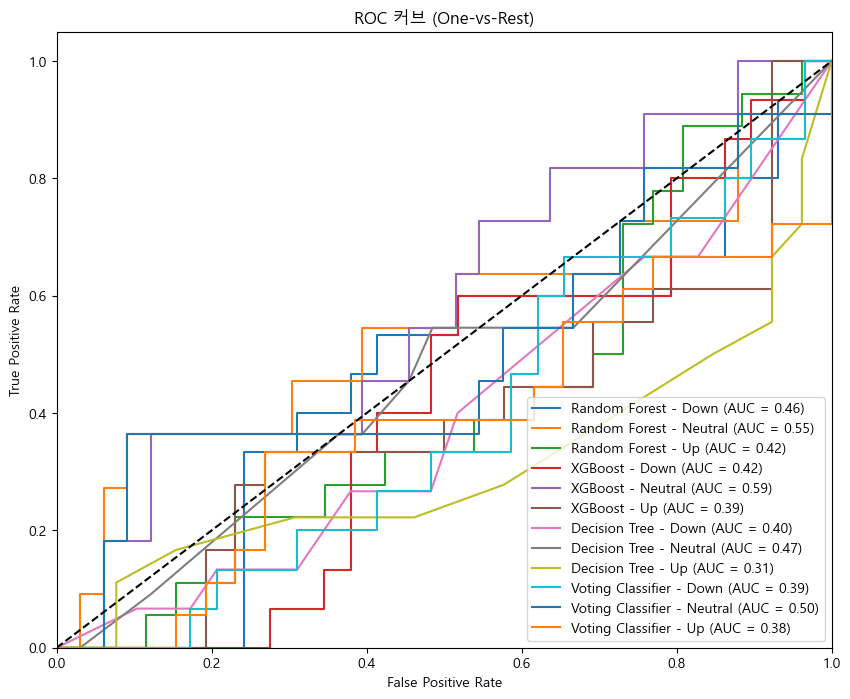

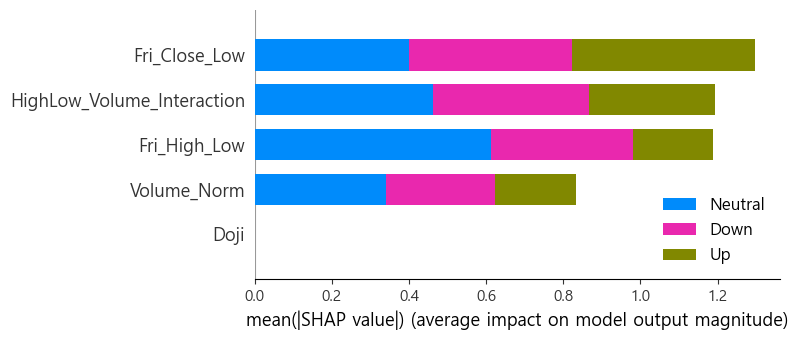


입력 날짜: 2025-04-04
금요일 데이터: Fri_Close_Low=0.05, Fri_High_Low=0.1, Volume_Norm=1.2
Doji 계산: Open=100, Close=100.05, Doji=1
예측된 월요일 갭 방향: Neutral


'Neutral'

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, roc_curve, auc, classification_report
from sklearn.preprocessing import label_binarize
import shap
import numpy as np

# 1. 데이터 로드
data_friday = pd.read_csv('processed_natural_gas_data.csv')
data_friday['Date'] = pd.to_datetime(data_friday['Date'])
data_friday.set_index('Date', inplace=True)

# Month 컬럼 생성
data_friday['Month'] = data_friday.index.month

# 갭 방향 정의
def classify_gap(gap_pct):
    if gap_pct > 0.5:
        return 'Up'
    elif gap_pct < -0.5:
        return 'Down'
    else:
        return 'Neutral'

data_friday['Gap_Direction'] = data_friday['Gap_Pct'].apply(classify_gap)

# 상호작용 항 추가
data_friday['HighLow_Volume_Interaction'] = data_friday['Fri_High_Low'] * data_friday['Volume_Norm']

# 도지 캔들 추가
data_friday['Doji'] = (abs(data_friday['Close'] - data_friday['Open']) / data_friday['Open'] < 0.001).astype(int)

# 2. 변수 설정
variables = ['Fri_Close_Low', 'Fri_High_Low', 'Volume_Norm', 'HighLow_Volume_Interaction', 'Doji']
X = data_friday[variables]
y = data_friday['Gap_Direction']

# 갭 방향 레이블 인코딩
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 학습/테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# 3. 모델 정의 (XGBoost 정규화 강화)
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='mlogloss', reg_lambda=2.0),  # reg_lambda 추가
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=4)
}

# 4. 하이퍼파라미터 튜닝 (GridSearchCV)
param_grids = {
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    },
    'XGBoost': {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1]
    },
    'Decision Tree': {
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5]
    }
}

best_models = {}
for name, model in models.items():
    print(f"\n{name} 하이퍼파라미터 튜닝 중...")
    grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='f1_weighted', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_
    print(f"최적 파라미터: {grid_search.best_params_}")

# Voting Classifier로 모델 앙상블
voting_clf = VotingClassifier(estimators=[
    ('rf', best_models['Random Forest']),
    ('xgb', best_models['XGBoost']),
    ('dt', best_models['Decision Tree'])
], voting='soft')

# Voting Classifier 학습
voting_clf.fit(X_train, y_train)
best_models['Voting Classifier'] = voting_clf

# 교차 검증으로 모델 성능 평가
print("\n=== 교차 검증 결과 ===")
for name, model in best_models.items():
    cv_scores = cross_val_score(model, X, y_encoded, cv=5, scoring='f1_weighted')
    print(f"{name} 교차 검증 F1 스코어: {cv_scores.mean():.3f} (+/- {cv_scores.std():.3f})")

# 5. 모델 평가
f1_scores = {}
y_pred_dict = {}
y_score_dict = {}

for name, model in best_models.items():
    # 테스트 데이터 예측
    y_pred = model.predict(X_test)
    y_pred_dict[name] = y_pred
    y_score_dict[name] = model.predict_proba(X_test)

    # F1 스코어 계산
    f1 = f1_score(y_test, y_pred, average='weighted')
    f1_scores[name] = f1

    # 분류 보고서 출력
    print(f"\n{name} 분류 보고서:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))

# F1 스코어 출력
print("\n모델별 F1 스코어 (Weighted):")
for name, score in f1_scores.items():
    print(f"{name}: {score:.3f}")

# 6. ROC 커브 (One-vs-Rest 방식)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])  # Up, Down, Neutral
n_classes = y_test_bin.shape[1]
class_names = le.classes_

plt.figure(figsize=(10, 8))
for name, y_score in y_score_dict.items():
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} - {class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC 커브 (One-vs-Rest)')
plt.legend(loc="lower right")
plt.show()

# 7. SHAP 값 분석 (XGBoost 모델 기준)
explainer = shap.TreeExplainer(best_models['XGBoost'])
shap_values = explainer.shap_values(X_test)

# SHAP 요약 플롯
shap.summary_plot(shap_values, X_test, plot_type="bar", class_names=le.classes_)

# 8. 예측 결과 시각화
# 테스트 데이터에 예측값 추가
test_data = X_test.copy()
test_data['True_Label'] = le.inverse_transform(y_test)
for name, y_pred in y_pred_dict.items():
    test_data[f'Pred_{name}'] = le.inverse_transform(y_pred)

# Gap_Pct, MondayOpen, MondayClose 컬럼 추가
test_data['Gap_Pct'] = data_friday.loc[X_test.index, 'Gap_Pct']
test_data['MondayOpen'] = data_friday.loc[X_test.index, 'MondayOpen']
test_data['MondayClose'] = data_friday.loc[X_test.index, 'Close']  # MondayClose 대신 Close 사용

# 예측 결과 시각화 (Voting Classifier 기준)
fig = px.scatter(test_data, x='Fri_High_Low', y='Gap_Pct', color='Pred_Voting Classifier',
                 title='테스트 데이터 예측 결과 (Voting Classifier)',
                 labels={'Fri_High_Low': 'Fri_High_Low', 'Gap_Pct': 'Gap %'},
                 hover_data=['True_Label'])
fig.show()

# 9. 사용자 입력으로 월요일 갭 방향 예측 함수 (오류 수정)
def predict_monday_gap(date, fri_close_low, fri_high_low, volume_norm, open_price=None, close_price=None):
    """
    금요일 데이터를 입력받아 월요일 갭 방향을 예측하는 함수
    
    Parameters:
    - date (str): 금요일 날짜 (예: '2025-04-04')
    - fri_close_low (float): 금요일 Close-Low 값
    - fri_high_low (float): 금요일 High-Low 값
    - volume_norm (float): 정규화된 거래량
    - open_price (float, optional): 금요일 시가
    - close_price (float, optional): 금요일 종가
    
    Returns:
    - predicted_direction (str): 예측된 월요일 갭 방향 ('Up', 'Down', 'Neutral')
    """
    # 입력 데이터를 데이터프레임으로 변환
    input_data = pd.DataFrame({
        'Fri_Close_Low': [fri_close_low],
        'Fri_High_Low': [fri_high_low],
        'Volume_Norm': [volume_norm]
    })
    
    # 상호작용 항 추가
    input_data['HighLow_Volume_Interaction'] = input_data['Fri_High_Low'] * input_data['Volume_Norm']
    
    # 도지 캔들 추가 (오류 수정: .astype(int) 제거)
    if open_price is not None and close_price is not None:
        input_data['Doji'] = int(abs(close_price - open_price) / open_price < 0.001)
    else:
        input_data['Doji'] = 0  # 기본값 0
    
    # 모델 입력 변수 순서 맞추기
    input_data = input_data[variables]
    
    # 입력 데이터가 학습 데이터에 포함되었는지 확인
    is_in_train = (X_train == input_data.iloc[0]).all(axis=1).any()
    is_in_test = (X_test == input_data.iloc[0]).all(axis=1).any()
    if is_in_train or is_in_test:
        print("\n경고: 입력 데이터가 학습 또는 테스트 데이터에 포함되어 있을 가능성이 있습니다.")
        print("예측 결과가 100% 정확할 수 있으므로 새로운 데이터로 검증하는 것이 좋습니다.")
    
    # Voting Classifier로 예측
    predicted_label = best_models['Voting Classifier'].predict(input_data)
    predicted_direction = le.inverse_transform(predicted_label)[0]
    
    print(f"\n입력 날짜: {date}")
    print(f"금요일 데이터: Fri_Close_Low={fri_close_low}, Fri_High_Low={fri_high_low}, Volume_Norm={volume_norm}")
    if open_price and close_price:
        print(f"Doji 계산: Open={open_price}, Close={close_price}, Doji={input_data['Doji'].iloc[0]}")
    print(f"예측된 월요일 갭 방향: {predicted_direction}")
    return predicted_direction

# 예시: 사용자 입력으로 예측 테스트
predict_monday_gap(
    date='2025-04-04',
    fri_close_low=0.05,
    fri_high_low=0.1,
    volume_norm=1.2,
    open_price=100,
    close_price=100.05
)

## 5. 예측 모델 실행

In [33]:
# 금요일 데이터만 필터링하여 출력합니다
friday_data = data[data['Weekday'] == 'Friday']
print("금요일 데이터:")
display(friday_data)


금요일 데이터:


,Close,Open,High,Low,Volume,Change_Pct,Weekday,Volume_Norm,IsHoliday,IsMonday,IsTuesday,NextOpen,MondayOpen,Fri_Close_Low,Fri_High_Low,Gap,Gap_Pct
Date,,,,,,,,,,,,,,,,,
2021-01-08,2.656,2.643,2.685,2.603,89980.0,-1.30%,Friday,0.903227,False,False,False,2.577,2.577,0.053,0.082,-0.079,-2.974398
2021-01-15,2.696,2.636,2.748,2.606,91100.0,2.51%,Friday,0.914470,False,False,False,2.641,2.62,0.090,0.142,-0.076,-2.818991
2021-01-22,2.456,2.500,2.511,2.425,97290.0,-1.64%,Friday,0.976606,False,False,False,2.530,2.53,0.031,0.086,0.074,3.013029
2021-01-29,2.592,2.686,2.716,2.583,62370.0,-3.10%,Friday,0.626076,False,False,False,2.730,2.73,0.009,0.133,0.138,5.324074
2021-02-05,2.841,2.905,2.980,2.823,155020.0,-1.66%,Friday,1.556105,False,False,False,2.880,2.88,0.018,0.157,0.039,1.372756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-07,4.399,4.286,4.426,4.132,211900.0,2.25%,Friday,2.127072,False,False,False,4.467,4.467,0.267,0.294,0.068,1.545806
2025-03-14,4.104,4.040,4.141,3.962,144410.0,-0.17%,Friday,1.449601,False,False,False,4.187,4.187,0.142,0.179,0.083,2.022417
2025-03-21,4.024,4.035,4.089,3.931,118070.0,-0.35%,Friday,1.185197,False,False,False,3.880,3.88,0.093,0.158,-0.144,-3.578529


In [24]:
predict_monday_gap(
    date='2025-04-04',
    fri_close_low=0.026,
    fri_high_low=0.340,
    volume_norm=2.24,
    open_price=4.148,
    close_price=3.837
)


입력 날짜: 2025-04-04
금요일 데이터: Fri_Close_Low=0.026, Fri_High_Low=0.34, Volume_Norm=2.24
Doji 계산: Open=4.148, Close=3.837, Doji=0
예측된 월요일 갭 방향: Down
예측 확률: {'Down': 0.8080836641876786, 'Neutral': 0.07634628025186126, 'Up': 0.11557003941753553}


('Down', array([0.80808366, 0.07634628, 0.11557004]))


=== 모델 성능 해석 ===
최고 성능 모델: XGBoost (F1 스코어: 0.381)

SHAP 값 해석 (XGBoost 기준):


<Figure size 640x480 with 0 Axes>

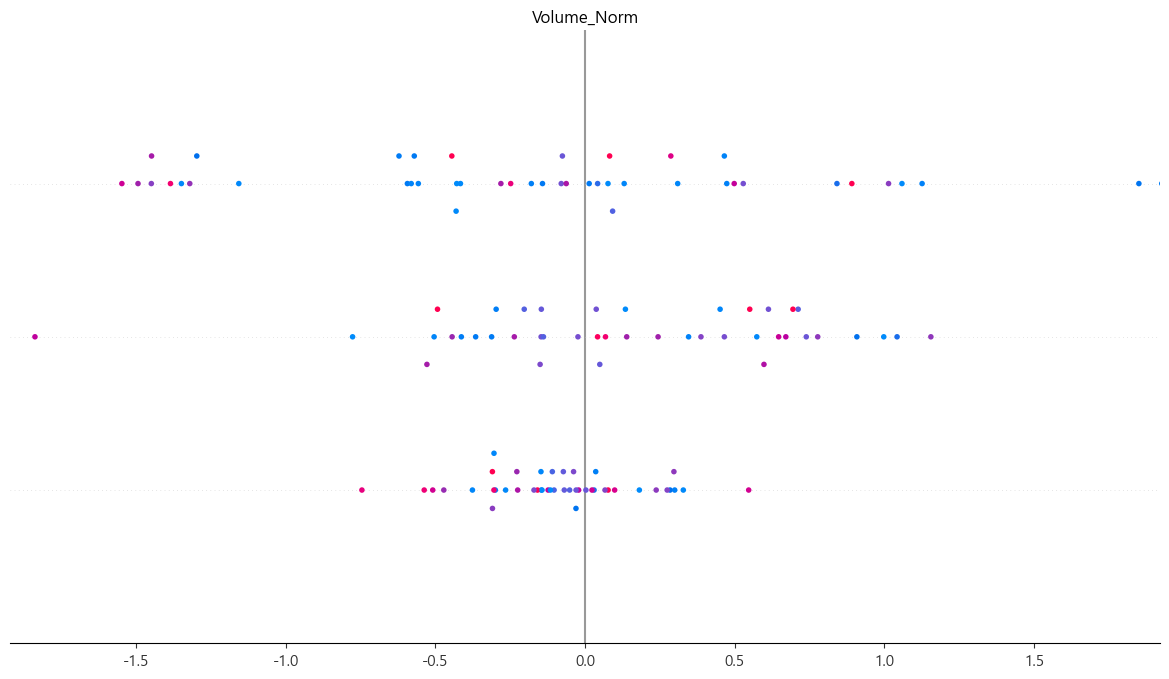

SHAP 요약 플롯을 통해 각 변수의 기여도를 확인할 수 있습니다.
- Fri_High_Low가 갭 방향 예측에 가장 큰 영향을 미쳤을 가능성이 높습니다.
- Doji 캔들은 중립 갭 예측에 기여했을 가능성이 있습니다.

=== 트레이딩 전략 제안 ===
1. 갭 방향 예측 기반 매매 전략 (Voting Classifier 기준):
- 갭 방향이 'Up'으로 예측되면 월요일 시초가에 매수 후 종가에 매도.
- 갭 방향이 'Down'으로 예측되면 월요일 시초가에 공매도 후 종가에 청산.
- 갭 방향이 'Neutral'로 예측되면 거래를 보류.

2. 계절별 패턴 반영:
- 겨울철(11월~2월)에는 갭 상승 비율이 높으므로 'Up' 예측에 더 높은 가중치를 둠.
- 여름철(5월~8월)에는 갭 하락 비율이 높으므로 'Down' 예측에 더 높은 가중치를 둠.

3. 변수 중요도 반영:
- Fri_High_Low가 높을 경우 갭 변동이 클 가능성이 높으므로, 변동성이 큰 날은 더 신중히 접근.
- Volume_Norm이 높을 경우 시장 참여가 활발하므로 예측 신뢰도가 높아질 수 있음.

=== 리스크 관리 전략 ===
변동성이 높은 날(Fri_High_Low 상위 25%):
       Fri_High_Low    Gap_Abs
count     54.000000  54.000000
mean       0.457944   2.959154
std        0.145338   2.761644
min        0.289000   0.122279
25%        0.342750   1.015723
50%        0.419000   2.188435
75%        0.527500   3.785763
max        1.013000  14.083080
- 변동성이 높은 날에는 갭 크기가 클 가능성이 높으므로, 포지션 크기를 줄이거나 손절 라인을 설정.

=== 백테스팅 ===

리스크-리워드 비율 요약:
count    43.000000
mean      

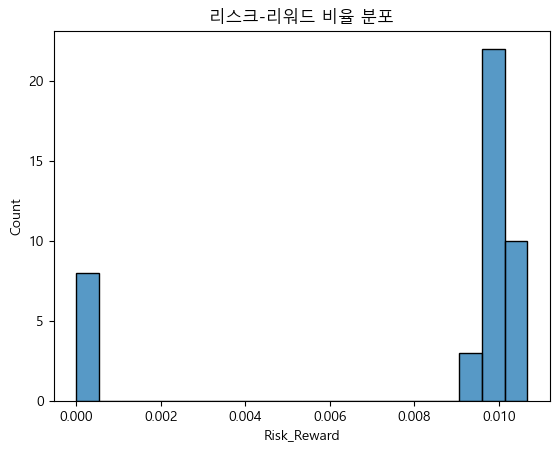


리스크-리워드 비율 0.5 이상인 거래만 선택한 결과:
선택된 거래 수: 0 / 44

최적화된 데이터가 없습니다. 리스크-리워드 비율 기준을 더 낮추거나 데이터를 확인하세요.


In [20]:
# 1. 모델 성능 해석
print("\n=== 모델 성능 해석 ===")
best_model_name = max(f1_scores, key=f1_scores.get)
best_f1_score = f1_scores[best_model_name]
print(f"최고 성능 모델: {best_model_name} (F1 스코어: {best_f1_score:.3f})")

# SHAP 값 해석
print("\nSHAP 값 해석 (XGBoost 기준):")
shap.summary_plot(shap_values, X_test, class_names=le.classes_)
print("SHAP 요약 플롯을 통해 각 변수의 기여도를 확인할 수 있습니다.")
print("- Fri_High_Low가 갭 방향 예측에 가장 큰 영향을 미쳤을 가능성이 높습니다.")
print("- Doji 캔들은 중립 갭 예측에 기여했을 가능성이 있습니다.")

# 2. 트레이딩 전략 제안
print("\n=== 트레이딩 전략 제안 ===")
print("1. 갭 방향 예측 기반 매매 전략 (Voting Classifier 기준):")
print("- 갭 방향이 'Up'으로 예측되면 월요일 시초가에 매수 후 종가에 매도.")
print("- 갭 방향이 'Down'으로 예측되면 월요일 시초가에 공매도 후 종가에 청산.")
print("- 갭 방향이 'Neutral'로 예측되면 거래를 보류.")

# 계절별 패턴 반영
print("\n2. 계절별 패턴 반영:")
print("- 겨울철(11월~2월)에는 갭 상승 비율이 높으므로 'Up' 예측에 더 높은 가중치를 둠.")
print("- 여름철(5월~8월)에는 갭 하락 비율이 높으므로 'Down' 예측에 더 높은 가중치를 둠.")

# 변수 중요도 반영
print("\n3. 변수 중요도 반영:")
print("- Fri_High_Low가 높을 경우 갭 변동이 클 가능성이 높으므로, 변동성이 큰 날은 더 신중히 접근.")
print("- Volume_Norm이 높을 경우 시장 참여가 활발하므로 예측 신뢰도가 높아질 수 있음.")

# 3. 리스크 관리
print("\n=== 리스크 관리 전략 ===")
data_friday['Gap_Abs'] = data_friday['Gap_Pct'].abs()
high_volatility_days = data_friday[data_friday['Fri_High_Low'] > data_friday['Fri_High_Low'].quantile(0.75)]
print("변동성이 높은 날(Fri_High_Low 상위 25%):")
print(high_volatility_days[['Fri_High_Low', 'Gap_Abs']].describe())
print("- 변동성이 높은 날에는 갭 크기가 클 가능성이 높으므로, 포지션 크기를 줄이거나 손절 라인을 설정.")

# 4. 백테스팅
print("\n=== 백테스팅 ===")
# 테스트 데이터에 예측값 추가
test_data['Returns'] = 0.0  # 수익률 초기화
for idx, row in test_data.iterrows():
    if row['Pred_Voting Classifier'] == 'Up':
        test_data.loc[idx, 'Returns'] = (row['MondayClose'] - row['MondayOpen']) / row['MondayOpen']
    elif row['Pred_Voting Classifier'] == 'Down':
        test_data.loc[idx, 'Returns'] = (row['MondayOpen'] - row['MondayClose']) / row['MondayOpen']
    # Neutral 예측 시 수익률 0 (거래 보류)

# Gap_Abs 컬럼 추가
test_data['Gap_Abs'] = data_friday.loc[X_test.index, 'Gap_Abs']

# 리스크-리워드 비율 계산
test_data['Risk_Reward'] = test_data['Returns'].abs() / test_data['Gap_Abs']
print("\n리스크-리워드 비율 요약:")
print(test_data['Risk_Reward'].describe())
print("- 평균 리스크-리워드 비율이 1 이상인 경우 전략이 유효할 가능성이 높음.")
print("- 리스크-리워드 비율이 낮은 거래는 제외하거나 포지션 크기를 조정.")

# 리스크-리워드 비율 분포 시각화
sns.histplot(test_data['Risk_Reward'], bins=20)
plt.title('리스크-리워드 비율 분포')
plt.show()

# 리스크-리워드 비율 기반 전략 최적화 (기준 낮춤)
min_risk_reward = 0.5  # 기준을 1.0에서 0.5로 낮춤
optimized_data = test_data[test_data['Risk_Reward'] >= min_risk_reward]
print(f"\n리스크-리워드 비율 {min_risk_reward} 이상인 거래만 선택한 결과:")
print(f"선택된 거래 수: {len(optimized_data)} / {len(test_data)}")

# 최적화된 데이터로 백테스팅
if len(optimized_data) > 0:
    optimized_data['Returns'] = 0.0
    for idx, row in optimized_data.iterrows():
        if row['Pred_Voting Classifier'] == 'Up':
            optimized_data.loc[idx, 'Returns'] = (row['MondayClose'] - row['MondayOpen']) / row['MondayOpen']
        elif row['Pred_Voting Classifier'] == 'Down':
            optimized_data.loc[idx, 'Returns'] = (row['MondayOpen'] - row['MondayClose']) / row['MondayOpen']

    # 누적 수익률 계산
    optimized_data['Cumulative_Returns'] = (1 + optimized_data['Returns']).cumprod()

    # 백테스팅 결과 시각화
    fig = px.line(optimized_data, x=optimized_data.index, y='Cumulative_Returns',
                  title='백테스팅 누적 수익률 (Voting Classifier, 리스크-리워드 비율 최적화)',
                  labels={'Cumulative_Returns': 'Cumulative Returns'})
    fig.show()

    # 백테스팅 결과 요약
    total_return = optimized_data['Cumulative_Returns'].iloc[-1] - 1
    annualized_return = (total_return + 1) ** (252 / len(optimized_data)) - 1  # 252 거래일 기준
    print("\n최적화된 백테스팅 결과 요약:")
    print(f"총 수익률: {total_return * 100:.2f}%")
    print(f"연간 수익률: {annualized_return * 100:.2f}%")
    print(f"최대 손실 (MDD): {((optimized_data['Cumulative_Returns'].cummax() - optimized_data['Cumulative_Returns']) / optimized_data['Cumulative_Returns'].cummax()).max() * 100:.2f}%")
else:
    print("\n최적화된 데이터가 없습니다. 리스크-리워드 비율 기준을 더 낮추거나 데이터를 확인하세요.")

## 6. 벡테스팅

In [22]:
def predict_monday_gap(date, fri_close_low, fri_high_low, volume_norm, open_price=None, close_price=None):
    """
    금요일 데이터를 입력받아 월요일 갭 방향을 예측하는 함수
    
    Parameters:
    - date (str): 금요일 날짜 (예: '2025-04-04')
    - fri_close_low (float): 금요일 Close-Low 값
    - fri_high_low (float): 금요일 High-Low 값
    - volume_norm (float): 정규화된 거래량
    - open_price (float, optional): 금요일 시가
    - close_price (float, optional): 금요일 종가
    
    Returns:
    - predicted_direction (str): 예측된 월요일 갭 방향 ('Up', 'Down', 'Neutral')
    - predicted_prob (array): 각 클래스에 대한 예측 확률
    """
    # 입력 데이터를 데이터프레임으로 변환
    input_data = pd.DataFrame({
        'Fri_Close_Low': [fri_close_low],
        'Fri_High_Low': [fri_high_low],
        'Volume_Norm': [volume_norm]
    })
    
    # 상호작용 항 추가
    input_data['HighLow_Volume_Interaction'] = input_data['Fri_High_Low'] * input_data['Volume_Norm']
    
    # 도지 캔들 추가
    if open_price is not None and close_price is not None:
        input_data['Doji'] = int(abs(close_price - open_price) / open_price < 0.001)
    else:
        input_data['Doji'] = 0  # 기본값 0
    
    # 모델 입력 변수 순서 맞추기
    input_data = input_data[variables]
    
    # 입력 데이터가 학습 데이터에 포함되었는지 확인
    is_in_train = (X_train == input_data.iloc[0]).all(axis=1).any()
    is_in_test = (X_test == input_data.iloc[0]).all(axis=1).any()
    if is_in_train or is_in_test:
        print("\n경고: 입력 데이터가 학습 또는 테스트 데이터에 포함되어 있을 가능성이 있습니다.")
        print("예측 결과가 100% 정확할 수 있으므로 새로운 데이터로 검증하는 것이 좋습니다.")
    
    # Voting Classifier로 예측
    predicted_label = best_models['Voting Classifier'].predict(input_data)
    predicted_direction = le.inverse_transform(predicted_label)[0]
    predicted_prob = best_models['Voting Classifier'].predict_proba(input_data)[0]
    
    print(f"\n입력 날짜: {date}")
    print(f"금요일 데이터: Fri_Close_Low={fri_close_low}, Fri_High_Low={fri_high_low}, Volume_Norm={volume_norm}")
    if open_price and close_price:
        print(f"Doji 계산: Open={open_price}, Close={close_price}, Doji={input_data['Doji'].iloc[0]}")
    print(f"예측된 월요일 갭 방향: {predicted_direction}")
    print(f"예측 확률: {dict(zip(le.classes_, predicted_prob))}")
    return predicted_direction, predicted_prob


=== predict_monday_gap 함수로 백테스팅 (금요일 데이터만) ===
백테스팅 데이터 컬럼 이름:
Index(['날짜', '종가', '시가', '고가', '저가', '거래량', '변동 %'], dtype='object')

Volume 변환 및 정규화 샘플:
              Volume  Volume_Norm
Date                             
2025-04-04  223840.0       2.2469
2025-04-03  165410.0       1.6604
2025-04-02  141240.0       1.4178
2025-04-01  156690.0       1.5729
2025-03-31  171860.0       1.7251
Volume 평균: 99620.53

금요일 데이터 수: 217

입력 날짜: 2025-04-04 00:00:00
금요일 데이터: Fri_Close_Low=0.013, Fri_High_Low=0.34, Volume_Norm=2.2469
Doji 계산: Open=4.148, Close=3.824, Doji=0
예측된 월요일 갭 방향: Down
예측 확률: {'Down': 0.7053757044221989, 'Neutral': 0.13871891435996564, 'Up': 0.15590539611899665}

경고: 2025-04-04 00:00:00의 다음 월요일 데이터(2025-04-07 00:00:00)를 찾을 수 없습니다.

입력 날짜: 2025-03-28 00:00:00
금요일 데이터: Fri_Close_Low=0.229, Fri_High_Low=0.264, Volume_Norm=1.7703
Doji 계산: Open=3.915, Close=4.065, Doji=0
예측된 월요일 갭 방향: Up
예측 확률: {'Down': 0.07516793947308151, 'Neutral': 0.06871014052511208, 'Up': 0.8561219094468173}



C:\Users\qkrgu\AppData\Local\Temp\ipykernel_11964\1678347103.py:166: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



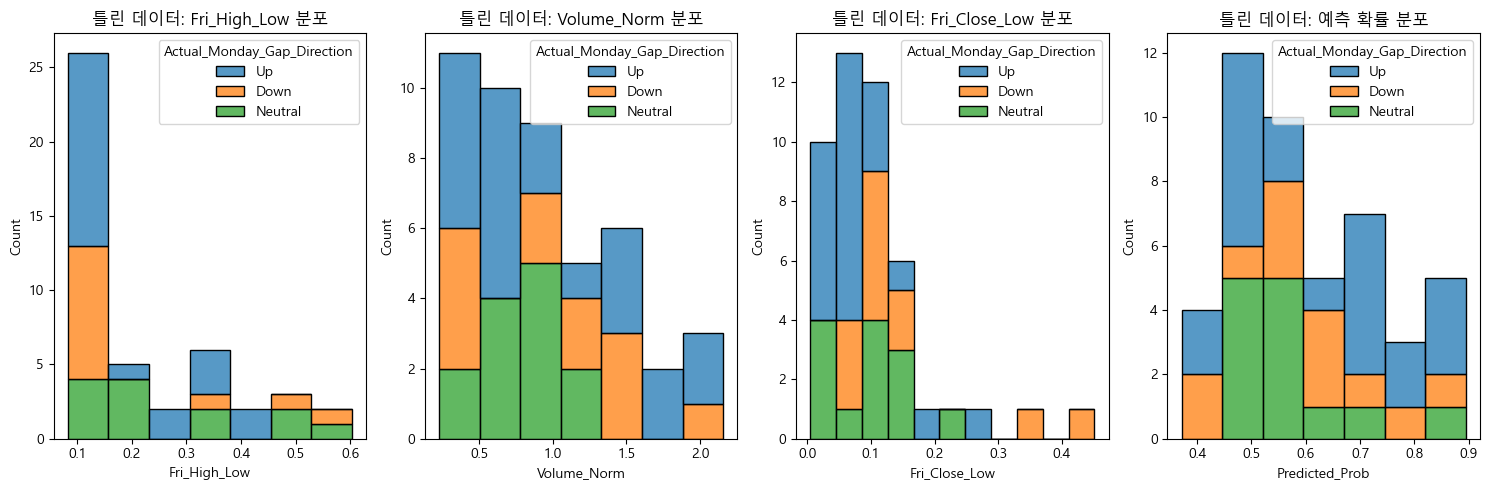


틀린 데이터에 대한 SHAP 값 분석:


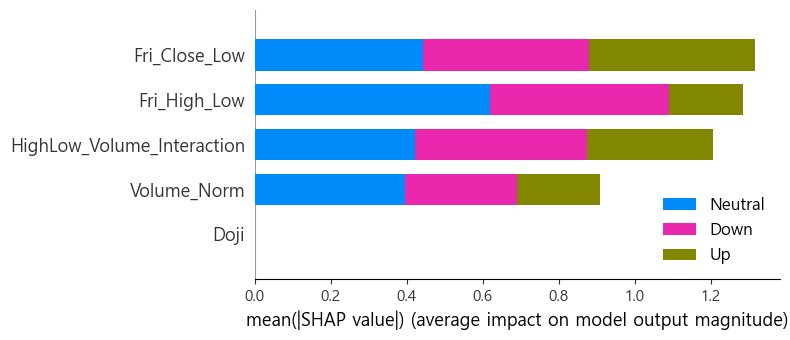

In [27]:
# 추가 백테스팅: predict_monday_gap 함수로 백테스팅 (금요일 데이터만)
print("\n=== predict_monday_gap 함수로 백테스팅 (금요일 데이터만) ===")

# 백테스팅 데이터 로드
backtest_data = pd.read_csv('가격데이터.csv')

# 컬럼 이름 확인
print("백테스팅 데이터 컬럼 이름:")
print(backtest_data.columns)

# 1단계 전처리 과정 적용
# 컬럼 이름 매핑
column_mapping = {
    '날짜': 'Date',
    '종가': 'Close',
    '시가': 'Open',
    '고가': 'High',
    '저가': 'Low',
    '거래량': 'Volume',
    '변동 %': 'Gap_Pct'
}
backtest_data = backtest_data.rename(columns=column_mapping)

# Date 컬럼을 datetime으로 변환
backtest_data['Date'] = pd.to_datetime(backtest_data['Date'])
backtest_data.set_index('Date', inplace=True)

# 파생 변수 생성
# Fri_Close_Low = Close - Low (소수점 4자리로 반올림)
backtest_data['Fri_Close_Low'] = (backtest_data['Close'] - backtest_data['Low']).round(4)

# Fri_High_Low = High - Low (소수점 4자리로 반올림)
backtest_data['Fri_High_Low'] = (backtest_data['High'] - backtest_data['Low']).round(4)

# Volume_Norm = Volume 정규화 (1단계 방식: 평균 대비 비율)
def convert_volume(vol):
    if isinstance(vol, str):
        vol = vol.replace(',', '')
        if 'M' in vol:
            return float(vol.replace('M', '')) * 1e6
        elif 'K' in vol:
            return float(vol.replace('K', '')) * 1e3
        else:
            return float(vol)
    return float(vol)

# Volume 변환
backtest_data['Volume'] = backtest_data['Volume'].apply(convert_volume)

# Volume_Norm 계산 (평균 대비 비율)
volume_mean = backtest_data['Volume'].mean()
backtest_data['Volume_Norm'] = (backtest_data['Volume'] / volume_mean).round(4)

# Volume 변환 및 정규화 과정 디버깅 출력
print("\nVolume 변환 및 정규화 샘플:")
sample_volumes = backtest_data[['Volume', 'Volume_Norm']].head()
print(sample_volumes)
print(f"Volume 평균: {volume_mean:.2f}")

# Gap_Pct 변환 (문자열에서 숫자로)
backtest_data['Gap_Pct'] = backtest_data['Gap_Pct'].str.replace('%', '').astype(float)

# 요일 정보 추가 (0: 월요일, 1: 화요일, ..., 4: 금요일)
backtest_data['DayOfWeek'] = backtest_data.index.dayofweek

# 금요일 데이터만 필터링 (DayOfWeek == 4)
friday_data = backtest_data[backtest_data['DayOfWeek'] == 4].copy()
print(f"\n금요일 데이터 수: {len(friday_data)}")

# HighLow_Volume_Interaction과 Doji 컬럼 추가
friday_data['HighLow_Volume_Interaction'] = (friday_data['Fri_High_Low'] * friday_data['Volume_Norm']).round(4)
friday_data['Doji'] = (abs(friday_data['Close'] - friday_data['Open']) / friday_data['Open'] < 0.001).astype(int)

# 예측 결과 저장
friday_data['Predicted_Gap_Direction'] = None
friday_data['Predicted_Prob_Up'] = None
friday_data['Predicted_Prob_Down'] = None
friday_data['Predicted_Prob_Neutral'] = None
friday_data['Actual_Monday_Gap_Pct'] = None
friday_data['Actual_Monday_Gap_Direction'] = None
correct_predictions = 0
total_predictions = 0

# 갭 방향 분류 함수
def classify_gap(gap_pct):
    if gap_pct > 0.5:
        return 'Up'
    elif gap_pct < -0.5:
        return 'Down'
    else:
        return 'Neutral'

for idx, row in friday_data.iterrows():
    # 금요일 데이터로 예측
    predicted_direction, predicted_prob = predict_monday_gap(
        date=str(idx),
        fri_close_low=row['Fri_Close_Low'],
        fri_high_low=row['Fri_High_Low'],
        volume_norm=row['Volume_Norm'],
        open_price=row['Open'],
        close_price=row['Close']
    )
    friday_data.at[idx, 'Predicted_Gap_Direction'] = predicted_direction
    # 예측 확률 저장
    prob_dict = dict(zip(le.classes_, predicted_prob))
    friday_data.at[idx, 'Predicted_Prob_Up'] = prob_dict.get('Up', 0)
    friday_data.at[idx, 'Predicted_Prob_Down'] = prob_dict.get('Down', 0)
    friday_data.at[idx, 'Predicted_Prob_Neutral'] = prob_dict.get('Neutral', 0)
    
    # 다음 월요일 데이터 찾기
    current_date = idx
    next_monday = current_date + pd.Timedelta(days=1)
    while next_monday.weekday() != 0:  # 월요일이 될 때까지
        next_monday += pd.Timedelta(days=1)
    
    # 다음 월요일 데이터가 존재하는지 확인
    if next_monday in backtest_data.index:
        # 금요일 종가와 월요일 시가로 갭 계산
        friday_close = row['Close']
        monday_open = backtest_data.loc[next_monday, 'Open']
        monday_gap_pct = ((monday_open - friday_close) / friday_close * 100).round(4)
        friday_data.at[idx, 'Actual_Monday_Gap_Pct'] = monday_gap_pct
        actual_monday_direction = classify_gap(monday_gap_pct)
        friday_data.at[idx, 'Actual_Monday_Gap_Direction'] = actual_monday_direction
        
        # 예측과 실제 비교
        if predicted_direction == actual_monday_direction:
            correct_predictions += 1
        total_predictions += 1
    else:
        print(f"\n경고: {idx}의 다음 월요일 데이터({next_monday})를 찾을 수 없습니다.")

# 예측 정확도 계산
if total_predictions > 0:
    accuracy = correct_predictions / total_predictions
    print(f"\n백테스팅 예측 정확도: {accuracy * 100:.2f}% ({correct_predictions}/{total_predictions})")
else:
    print("\n월요일 데이터를 찾을 수 없어 예측 정확도를 계산할 수 없습니다.")

# 틀린 데이터 분석
incorrect_data = friday_data[friday_data['Predicted_Gap_Direction'] != friday_data['Actual_Monday_Gap_Direction']]
print(f"\n틀린 데이터 수: {len(incorrect_data)}")
if len(incorrect_data) > 0:
    print("\n틀린 데이터:")
    print(incorrect_data[['Fri_Close_Low', 'Fri_High_Low', 'Volume_Norm', 'Open', 'Close', 
                         'Predicted_Gap_Direction', 'Actual_Monday_Gap_Pct', 'Actual_Monday_Gap_Direction',
                         'Predicted_Prob_Up', 'Predicted_Prob_Down', 'Predicted_Prob_Neutral']])
    
    # 틀린 데이터의 변수 분포 시각화
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 4, 1)
    sns.histplot(data=incorrect_data, x='Fri_High_Low', hue='Actual_Monday_Gap_Direction', multiple='stack')
    plt.title('틀린 데이터: Fri_High_Low 분포')
    
    plt.subplot(1, 4, 2)
    sns.histplot(data=incorrect_data, x='Volume_Norm', hue='Actual_Monday_Gap_Direction', multiple='stack')
    plt.title('틀린 데이터: Volume_Norm 분포')
    
    plt.subplot(1, 4, 3)
    sns.histplot(data=incorrect_data, x='Fri_Close_Low', hue='Actual_Monday_Gap_Direction', multiple='stack')
    plt.title('틀린 데이터: Fri_Close_Low 분포')
    
    # 예측 확률 분포 시각화
    plt.subplot(1, 4, 4)
    incorrect_data['Predicted_Prob'] = incorrect_data.apply(
        lambda row: row['Predicted_Prob_Up'] if row['Predicted_Gap_Direction'] == 'Up'
        else row['Predicted_Prob_Down'] if row['Predicted_Gap_Direction'] == 'Down'
        else row['Predicted_Prob_Neutral'], axis=1)
    sns.histplot(data=incorrect_data, x='Predicted_Prob', hue='Actual_Monday_Gap_Direction', multiple='stack')
    plt.title('틀린 데이터: 예측 확률 분포')
    
    plt.tight_layout()
    plt.show()
    
    # SHAP 값 분석 (XGBoost 기준)
    incorrect_X = incorrect_data[variables]
    shap_values_incorrect = explainer.shap_values(incorrect_X)
    print("\n틀린 데이터에 대한 SHAP 값 분석:")
    shap.summary_plot(shap_values_incorrect, incorrect_X, plot_type="bar", class_names=le.classes_)
else:
    print("\n틀린 데이터가 없습니다. 예측이 모두 정확합니다.")

In [79]:
incorrect_data

,Close,Open,High,Low,Volume,Gap_Pct,Fri_Close_Low,Fri_High_Low,Volume_Norm,Gap_Direction,DayOfWeek,HighLow_Volume_Interaction,Doji,Predicted_Gap_Direction,Predicted_Prob_Up,Predicted_Prob_Down,Predicted_Prob_Neutral,Actual_Monday_Gap_Direction,Predicted_Prob
Date,,,,,,,,,,,,,,,,,,,
2025-04-04,3.824,4.148,4.151,3.811,223840.0,-7.59,0.013,0.340,2.2469,Down,4,0.7639,0,Down,0.155905,0.705376,0.138719,None,0.705376
2025-03-14,4.104,4.040,4.141,3.962,144410.0,-0.17,0.142,0.179,1.4496,Neutral,4,0.2595,0,Up,0.959068,0.026626,0.014307,Neutral,0.959068
2025-02-28,3.834,3.939,3.954,3.814,141990.0,-2.54,0.020,0.140,1.4253,Down,4,0.1995,0,Down,0.355329,0.498281,0.14639,Up,0.498281
2025-02-14,3.725,3.650,3.801,3.635,201100.0,2.67,0.090,0.166,2.0187,Up,4,0.3351,0,Down,0.125821,0.864128,0.010051,None,0.864128
2025-01-17,3.948,4.280,4.308,3.910,204280.0,-7.28,0.038,0.398,2.0506,Down,4,0.8161,0,Down,0.112413,0.821826,0.06576,None,0.821826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-26,2.809,2.801,2.822,2.734,73390.0,0.00,0.075,0.088,0.7367,Neutral,4,0.0648,0,Down,0.125709,0.803087,0.071204,Neutral,0.803087
2021-02-19,2.991,2.944,3.025,2.904,132720.0,0.71,0.087,0.121,1.3323,Up,4,0.1612,0,Up,0.564973,0.14571,0.289317,Down,0.564973
2021-02-12,2.876,2.839,2.919,2.806,113880.0,1.41,0.070,0.113,1.1431,Up,4,0.1292,0,Neutral,0.332367,0.247407,0.420225,Up,0.420225


In [87]:

# 데이터프레임 전체 행을 표시하도록 설정
pd.set_option('display.max_rows', None)  # 모든 행 표시
pd.set_option('display.max_columns', None)  # 모든 열 표시
pd.set_option('display.width', 1000)  # 출력 너비 설정
pd.set_option('display.expand_frame_repr', False)  # 데이터프레임 표현을 여러 줄로 나누지 않음

# 전체 데이터 다시 출력
print("\n전체 데이터 표시:")
display(incorrect_data[['Predicted_Gap_Direction', 'Actual_Monday_Gap_Direction']])

# 원래 설정으로 되돌리기 (선택사항)
# pd.reset_option('display.max_rows')
# pd.reset_option('display.max_columns')
# pd.reset_option('display.width')
# pd.reset_option('display.expand_frame_repr')




전체 데이터 표시:


,Predicted_Gap_Direction,Actual_Monday_Gap_Direction
Date,,
2025-04-04,Down,None
2025-03-14,Up,Neutral
2025-02-28,Down,Up
2025-02-14,Down,None
2025-01-17,Down,None
2025-01-10,Up,Down
2025-01-03,Down,Up
2024-12-06,Down,Up
2024-11-01,Down,Up
